<a href="https://colab.research.google.com/github/KeysiYTS/comment-classifier-dl/blob/dev/DPL_V2_ToxicComment_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, InputLayer, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D

## Parameters

In [2]:
mpl.rcParams['figure.figsize'] = (7,5)

# Importing Dataset

In [3]:
EMBEDDING_FILE='/content/drive/MyDrive/0. Machine Learning/Projetos/Testes DPL/glove.6B.50d.txt'
TRAIN_DATA_FILE= '/content/drive/MyDrive/0. Machine Learning/Projetos/Toxic Comment/train.csv'

In [4]:
dataset = pd.read_csv(TRAIN_DATA_FILE)

## Separating X and Y

In [5]:
x = dataset[['comment_text']]
y = dataset.drop(columns=['comment_text','id'])

### Separating Train and Test

In [6]:
train, test, y_train, y_test = train_test_split(x, y,
                                                test_size=.3,
                                                random_state = 64)

# Preparing the data

In [7]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [8]:
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

## Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

In [10]:
def tokenize_pad(text, maxlen):
  list_tokenized = tokenizer.texts_to_sequences(text)
  cvtd_text = pad_sequences(list_tokenized, maxlen=maxlen)
  return cvtd_text

## Convert Text

In [11]:
x_train = tokenize_pad(list_sentences_train, maxlen)
x_test = tokenize_pad(list_sentences_test, maxlen)

## Reading the gLove file

In [12]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [13]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


## Creating the indexes

In [14]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [15]:
nb_words = min(max_features, len(word_index))

# Model

In [16]:
model = Sequential([
                    InputLayer(input_shape=(maxlen,)),
                    Embedding(max_features, embed_size, weights=[embedding_matrix]),
                    LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
                    GlobalMaxPool1D(),
                    Dense(50, activation="relu"),
                    Dense(6, activation="sigmoid")
                  ])

model.compile(loss='binary_crossentropy', optimizer='adam')

## Fit Function

In [17]:
def fit_model(xtrain, ytrain):
  model.fit(xtrain, ytrain, batch_size=32, 
            epochs=2, validation_split=0.2, verbose=0)

In [18]:
fit_model(x_train, y_train)

# Predict Function

In [19]:
def predict_text(xtest):
  predictions = model.predict(xtest, verbose=0)
  return predictions

In [20]:
predictions = predict_text(x_test)

# ROC Curve/Score

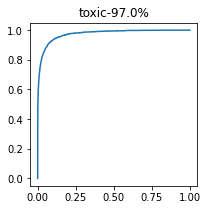

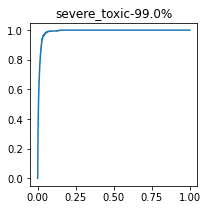

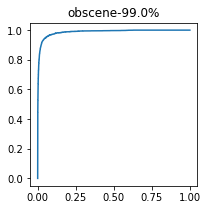

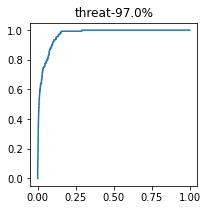

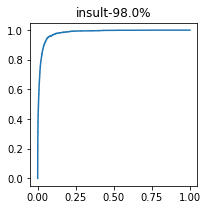

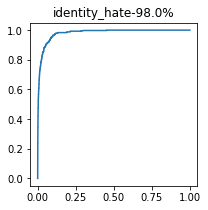

In [21]:
for idx,column in enumerate(y_test.columns):
  fpr, tpr, threshold = roc_curve(y_test[column], predictions[:,idx])
  plt.figure(figsize=(3,3))
  plt.plot(fpr, tpr, label = column)
  score = round(roc_auc_score(y_test[column], predictions[:,idx]),2)
  title = str(column) + '-' + str((score*100)) + '%'
  plt.title(title)

In [22]:
y_test.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [23]:
fpr0, tpr0, thresholds0 = roc_curve(y_test['toxic'], predictions[:,0])
fpr1, tpr1, thresholds1 = roc_curve(y_test['severe_toxic'], predictions[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test['obscene'], predictions[:,2])
fpr3, tpr3, thresholds3 = roc_curve(y_test['threat'], predictions[:,3])
fpr4, tpr4, thresholds4 = roc_curve(y_test['insult'], predictions[:,4])
fpr5, tpr5, thresholds5 = roc_curve(y_test['identity_hate'], predictions[:,5])

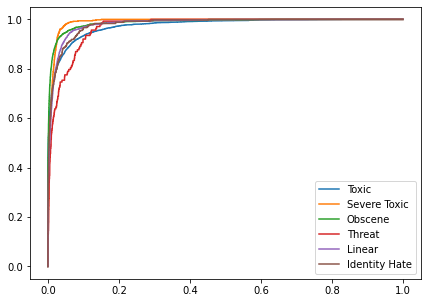

In [24]:
plt.plot(fpr0, tpr0, label= "Toxic")
plt.plot(fpr1, tpr1, label= "Severe Toxic")
plt.plot(fpr2, tpr2, label= "Obscene")
plt.plot(fpr3, tpr3, label= "Threat")
plt.plot(fpr4, tpr4, label= "Linear")
plt.plot(fpr5, tpr5, label= "Identity Hate")
plt.legend()
plt.show()

#test

In [25]:
a = "All asians are evil"

###process

In [26]:
phrase_list = []
phrase_list.append(a)
tkn_text = tokenize_pad(phrase_list, maxlen)
prediction = predict_text(tkn_text)
pred_percent = (predictions * 100)

###DF

In [27]:
pd.DataFrame(prediction, columns=y_test.columns.values).round(1)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.8,0.0,0.0,0.1,0.3,0.3
